In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
from sklearn import preprocessing
import warnings
import statsmodels.api as sm 
%matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore", category=UserWarning) 

We will load the raw and cleaned data into this notebook. These dataframes have been created in this [notebook](https://github.com/AlexBandurin/car_price_prediction/blob/master/Prediction_Modeling.ipynb)


In [10]:
####
df_raw = pd.read_csv('df_m_full_latest.csv')
####

In [20]:
####
df = pd.read_csv('car_data_sorted_Full.csv')
####

In [12]:
df.shape

(32293, 12)

We are getting rid of all the samples that don't have complete 'Year', 'Make', and 'Model' information as we can't use that data in our model.

Fortunately, it appears as we have 92-95% of our original data after doing this. 

## Missing Values

Note: We can disregard "Year", "Make", and "Model", as we have filtered those out already. We will also drop all the samples where the "Condition" variable is missing (around 15% of the dataset). 

Before dropping:

In [14]:
df_old = pd.read_csv('/Users/alex/Data_Science/Used_Cars/Used_Cars_Project/car_data_sorted_1.csv')

tot = len(df_old)
for i in ['Paint Color', 'Cylinders','Drive']:
    print('Percent with not null Condition and null ' + i + ': ' + str(round(100*df_old[(df_old["Condition"].notnull()) & (df_old[i].isnull()) ].shape[0]/tot,2))+ '%')
    print('Percent with null Condition and null ' + i + ': ' + str(round(100*df_old[(df_old["Condition"].isnull()) & (df_old[i].isnull()) ].shape[0]/tot,2))+ '%')

Percent with not null Condition and null Paint Color: 12.79%
Percent with null Condition and null Paint Color: 12.58%
Percent with not null Condition and null Cylinders: 13.91%
Percent with null Condition and null Cylinders: 12.14%
Percent with not null Condition and null Drive: 17.53%
Percent with null Condition and null Drive: 13.05%


It so happens that samples with that feature missing also have other features missing, which works in our favor. After dropping:

So we still have to take care of "Drive", "Paint Color", and "Cylinders".

To handle the remaining missing values, we will use imputation. But first, we will convert some of these categorical variables to numerical. Note: We are going to keep the missing value as "NaN" for now, and impute them using KNN imputer.

The categorical variables we are going to use in our model are: "Make", "Model", "Condition", "Paint Color", "Title Status", "Drive", and "Transmission". 

## EDA

Sample size: 32,293


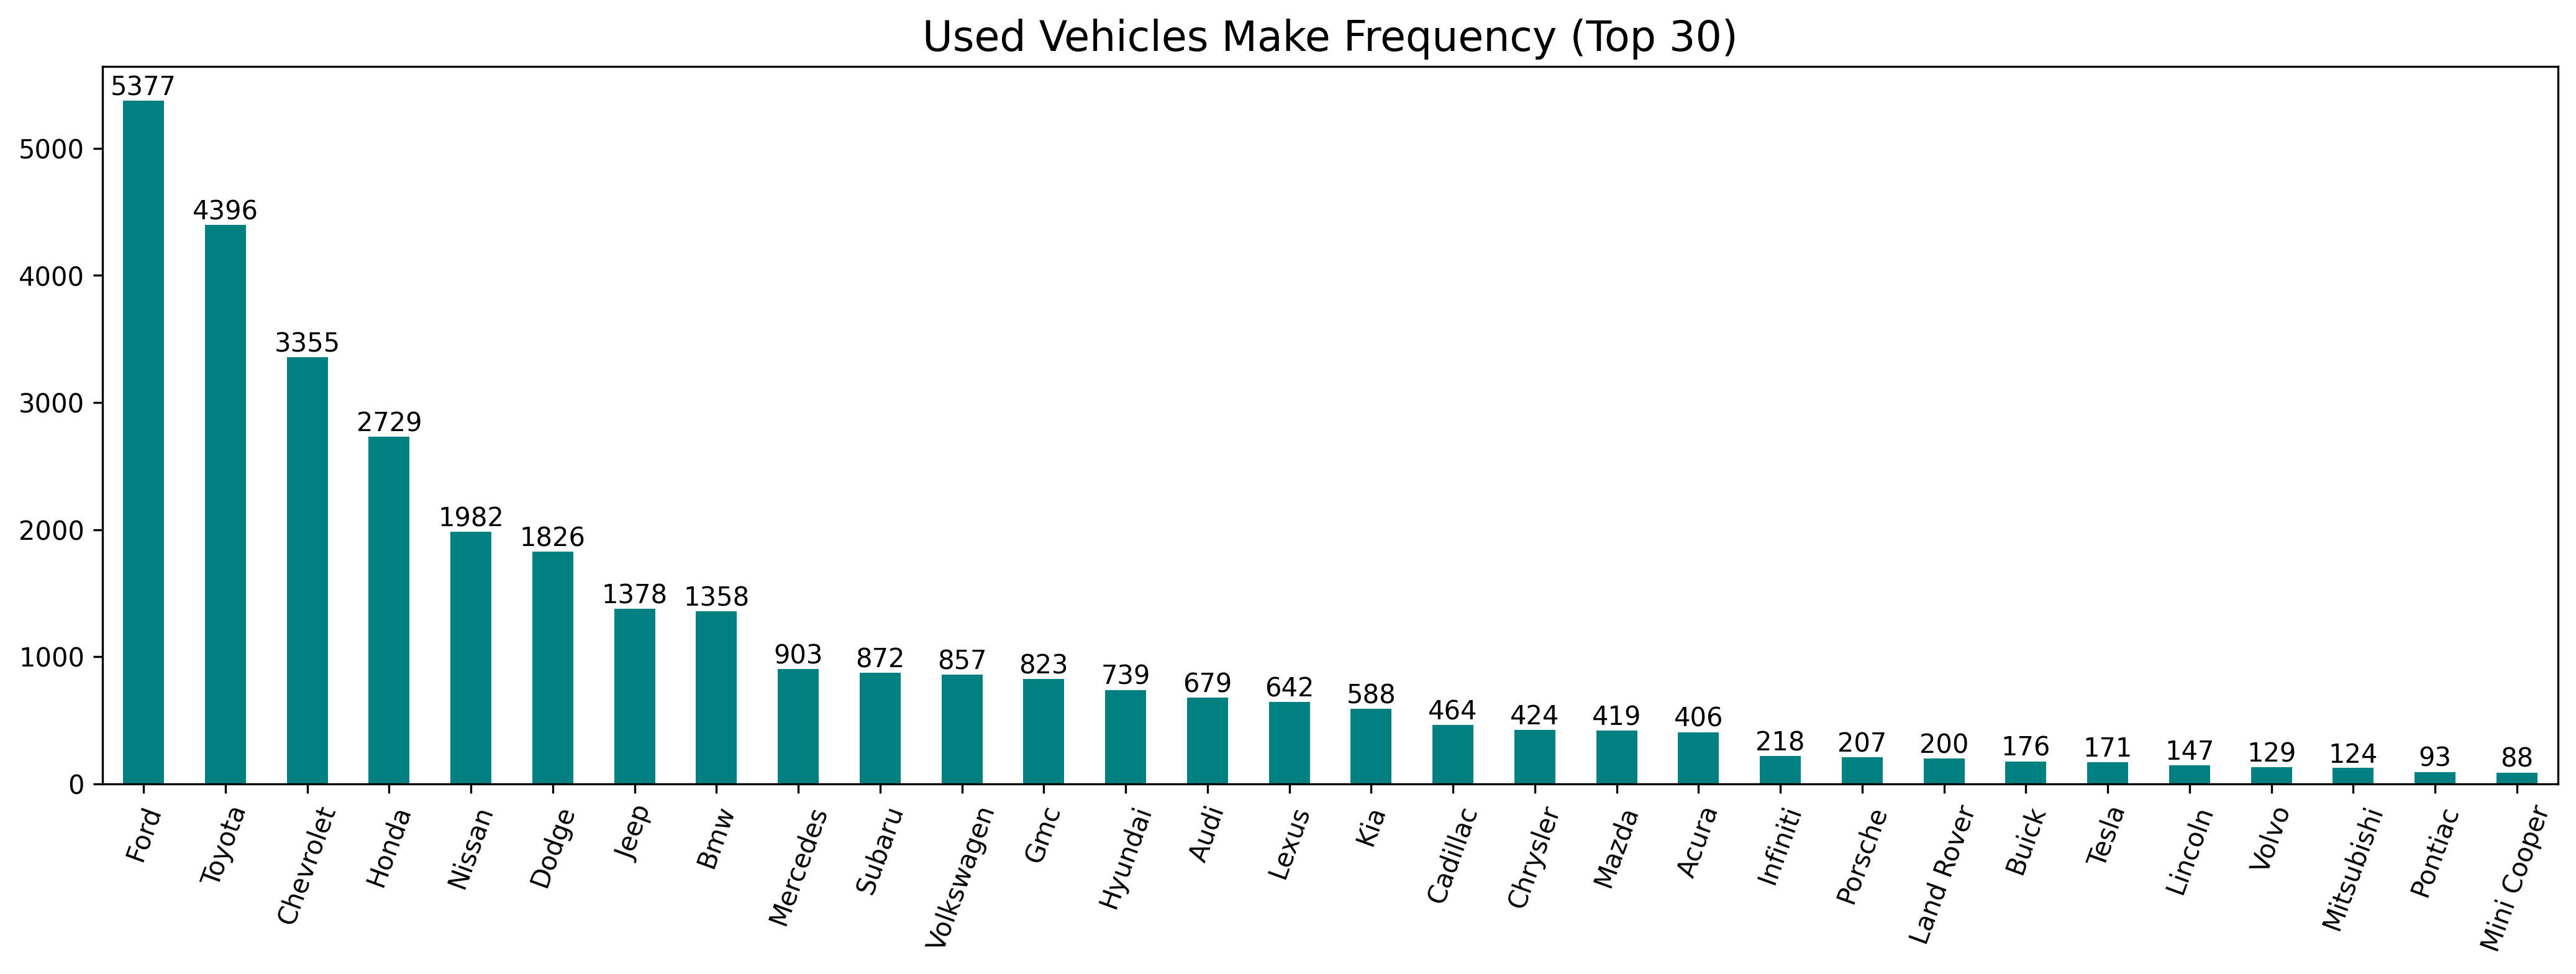

In [21]:
plt.figure(figsize = [17,5],dpi = 300)
ax = df['Make'].value_counts()[:30].plot(kind='bar', color = 'teal');
for bars in ax.containers:
    ax.bar_label(bars);
plt.xticks(rotation=70);
print("Sample size: " + str('{:,}'.format(len(df))))
plt.title("Used Vehicles Make Frequency (Top 30)", fontsize = 16);

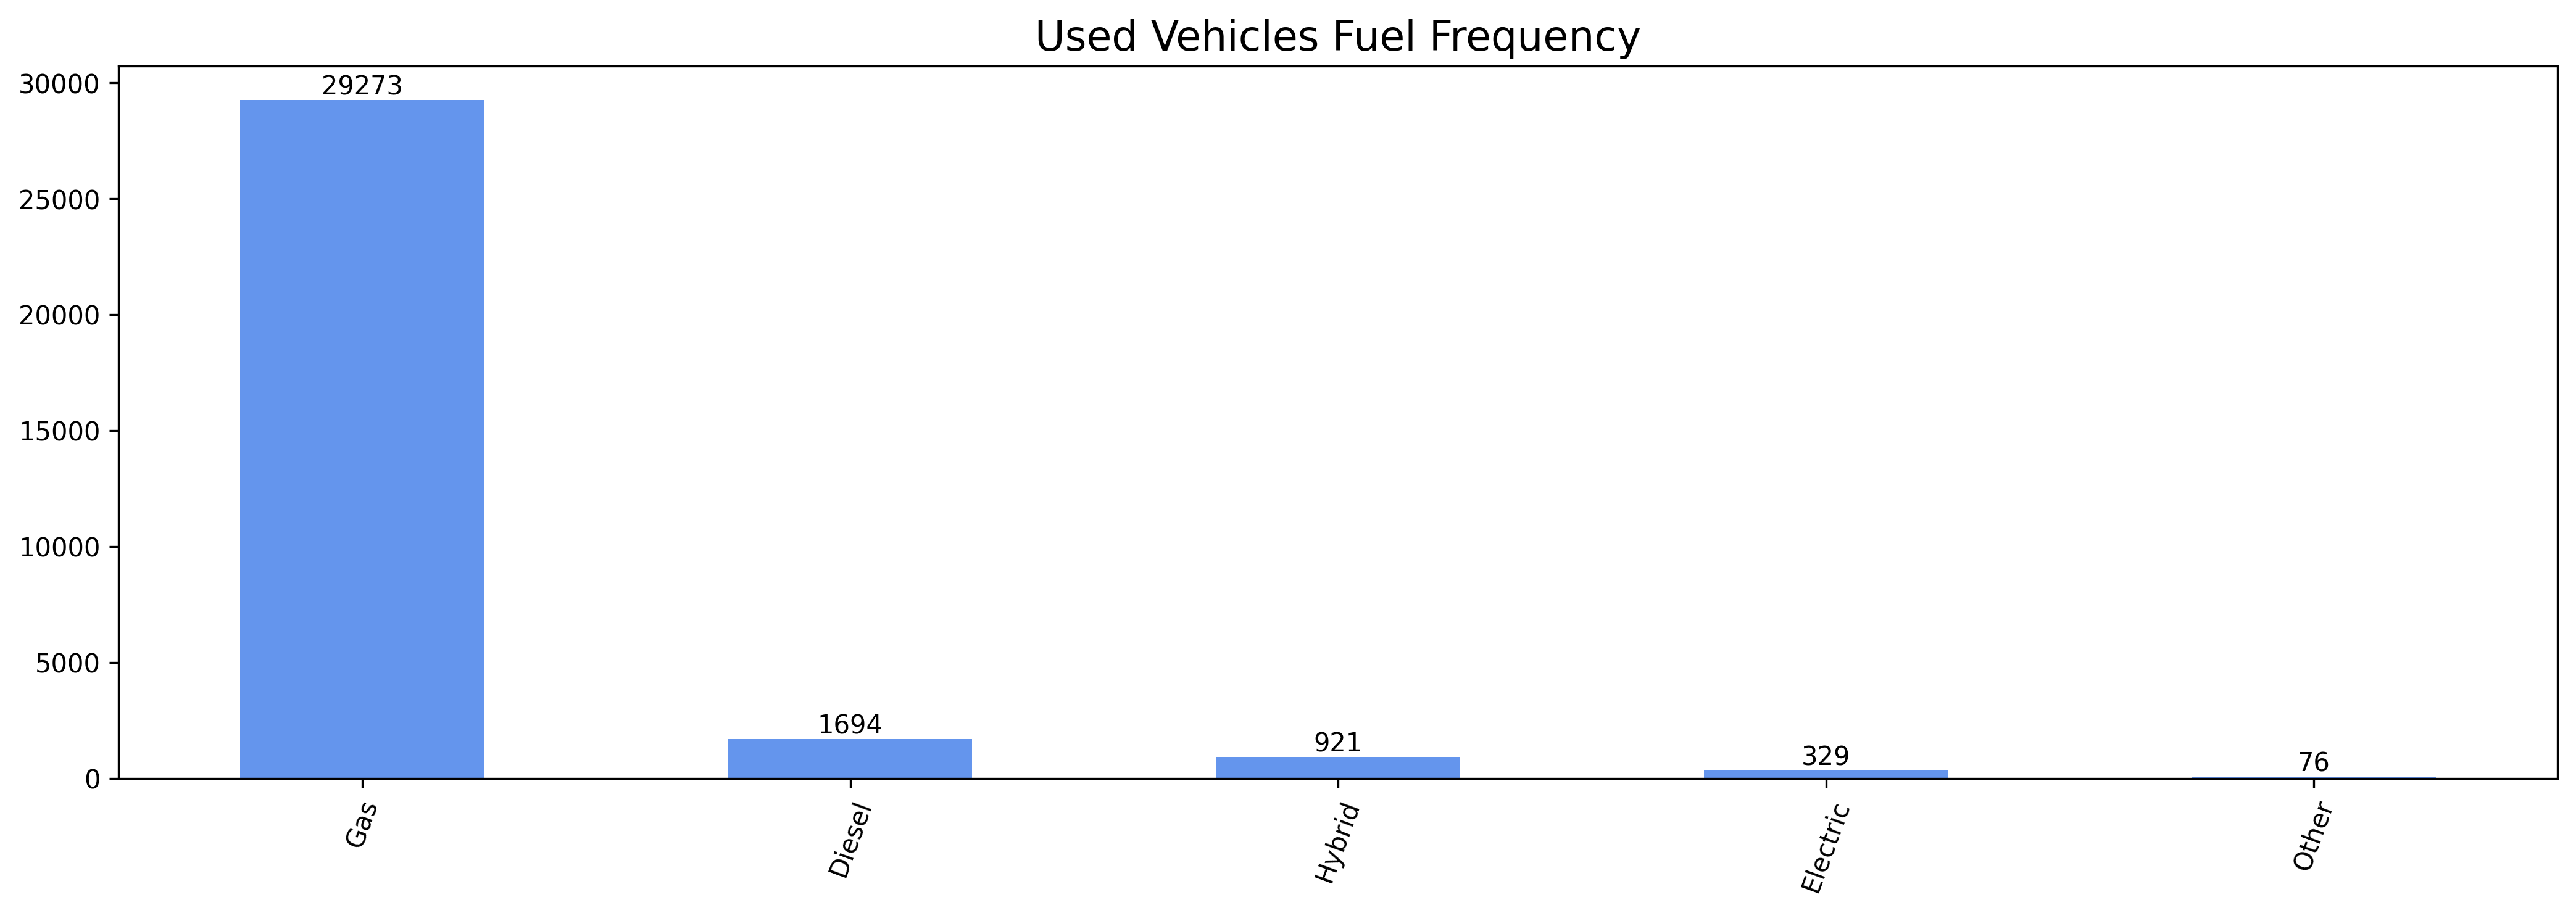

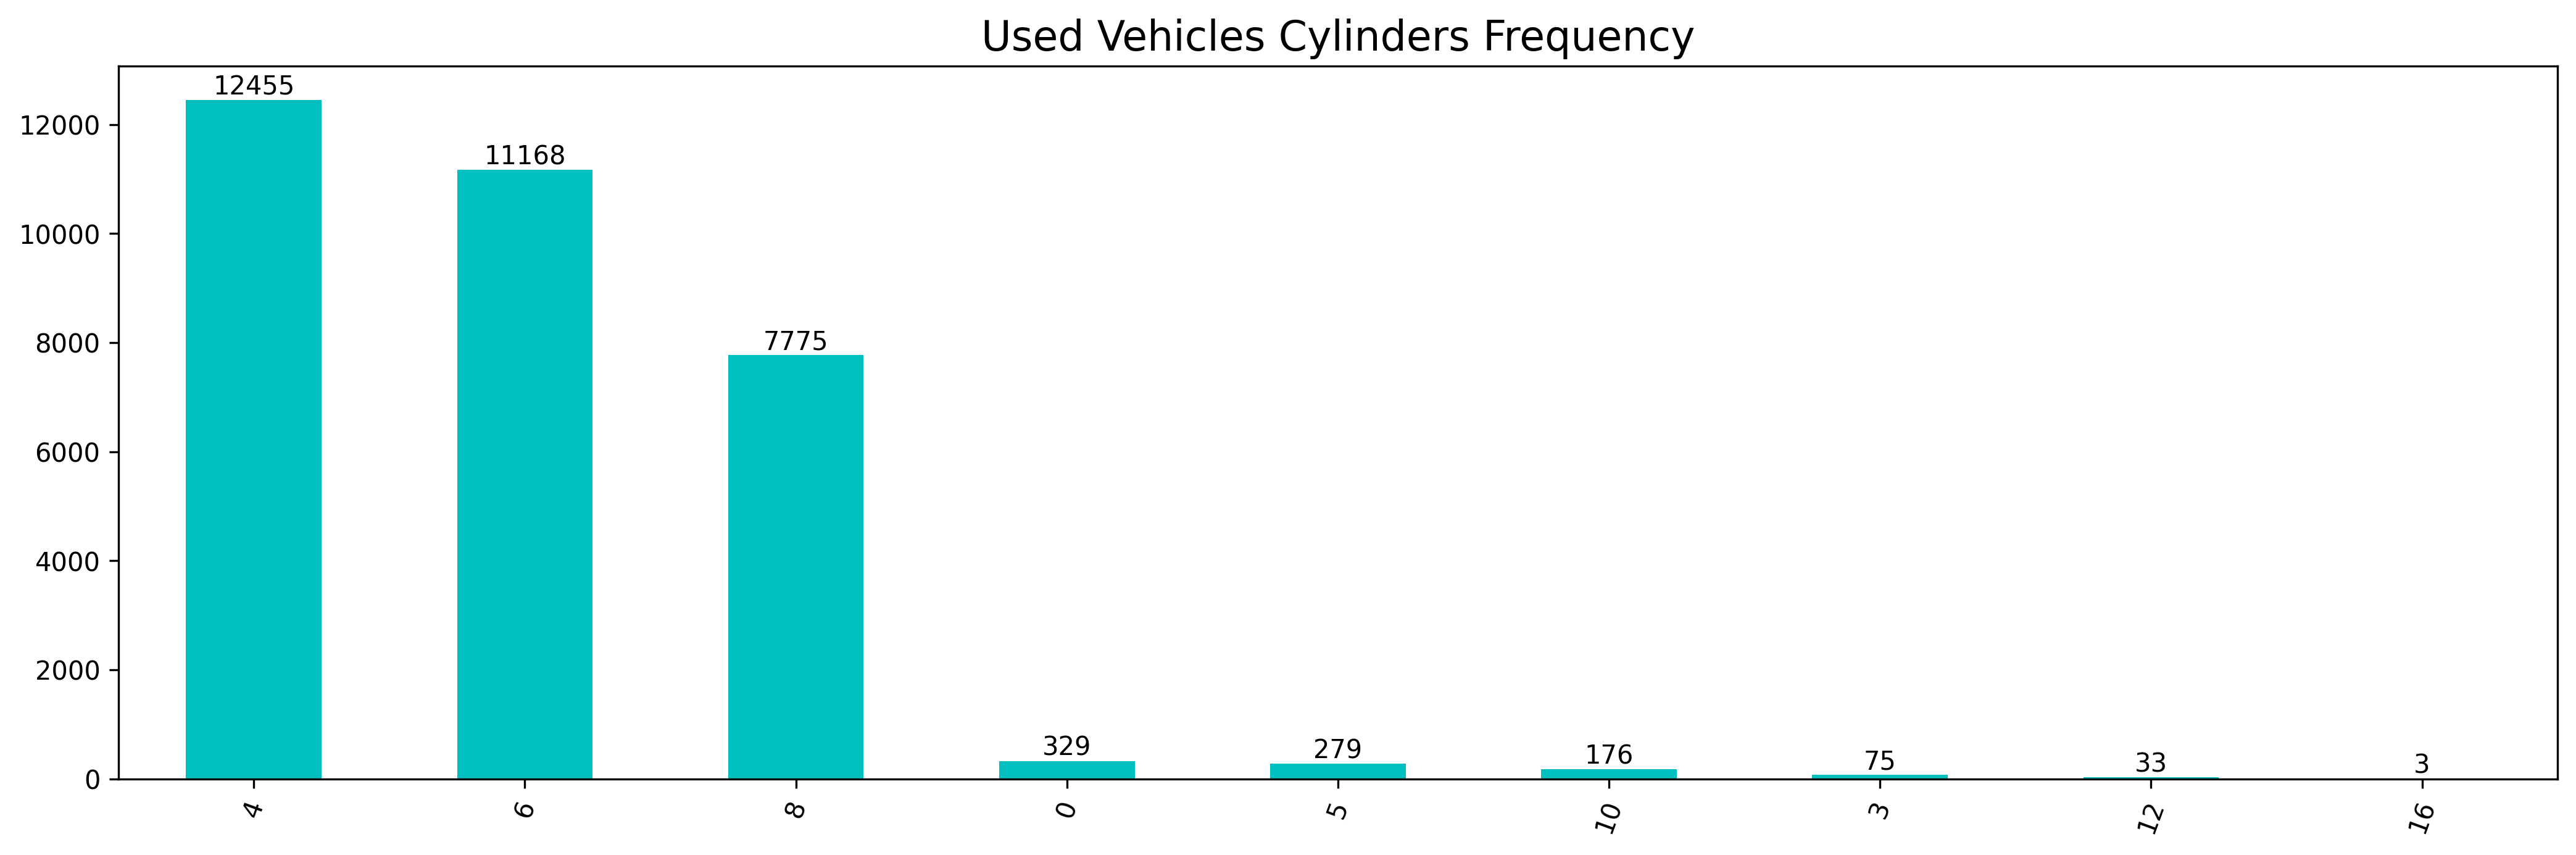

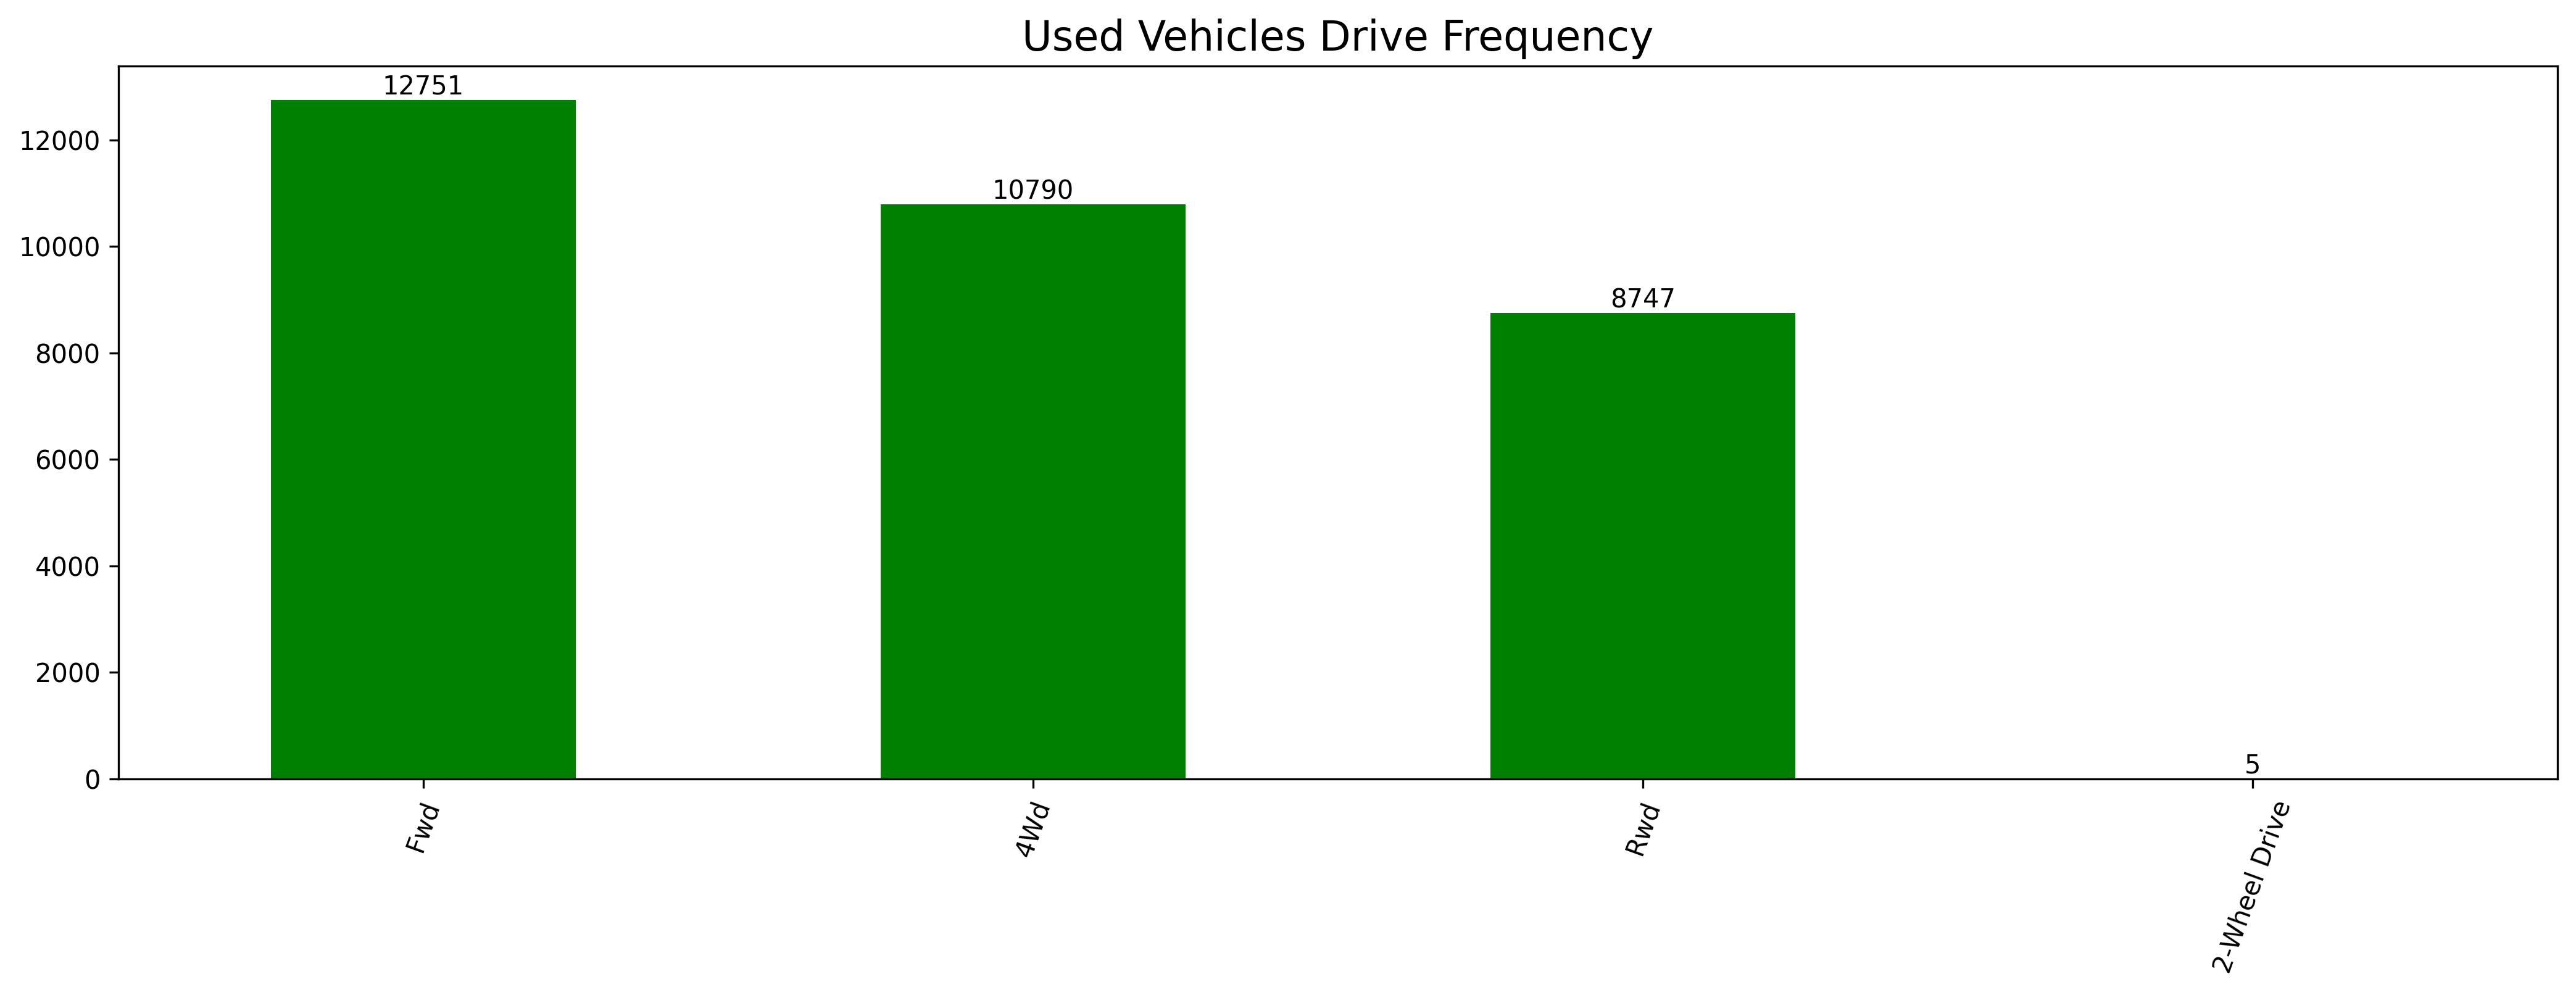

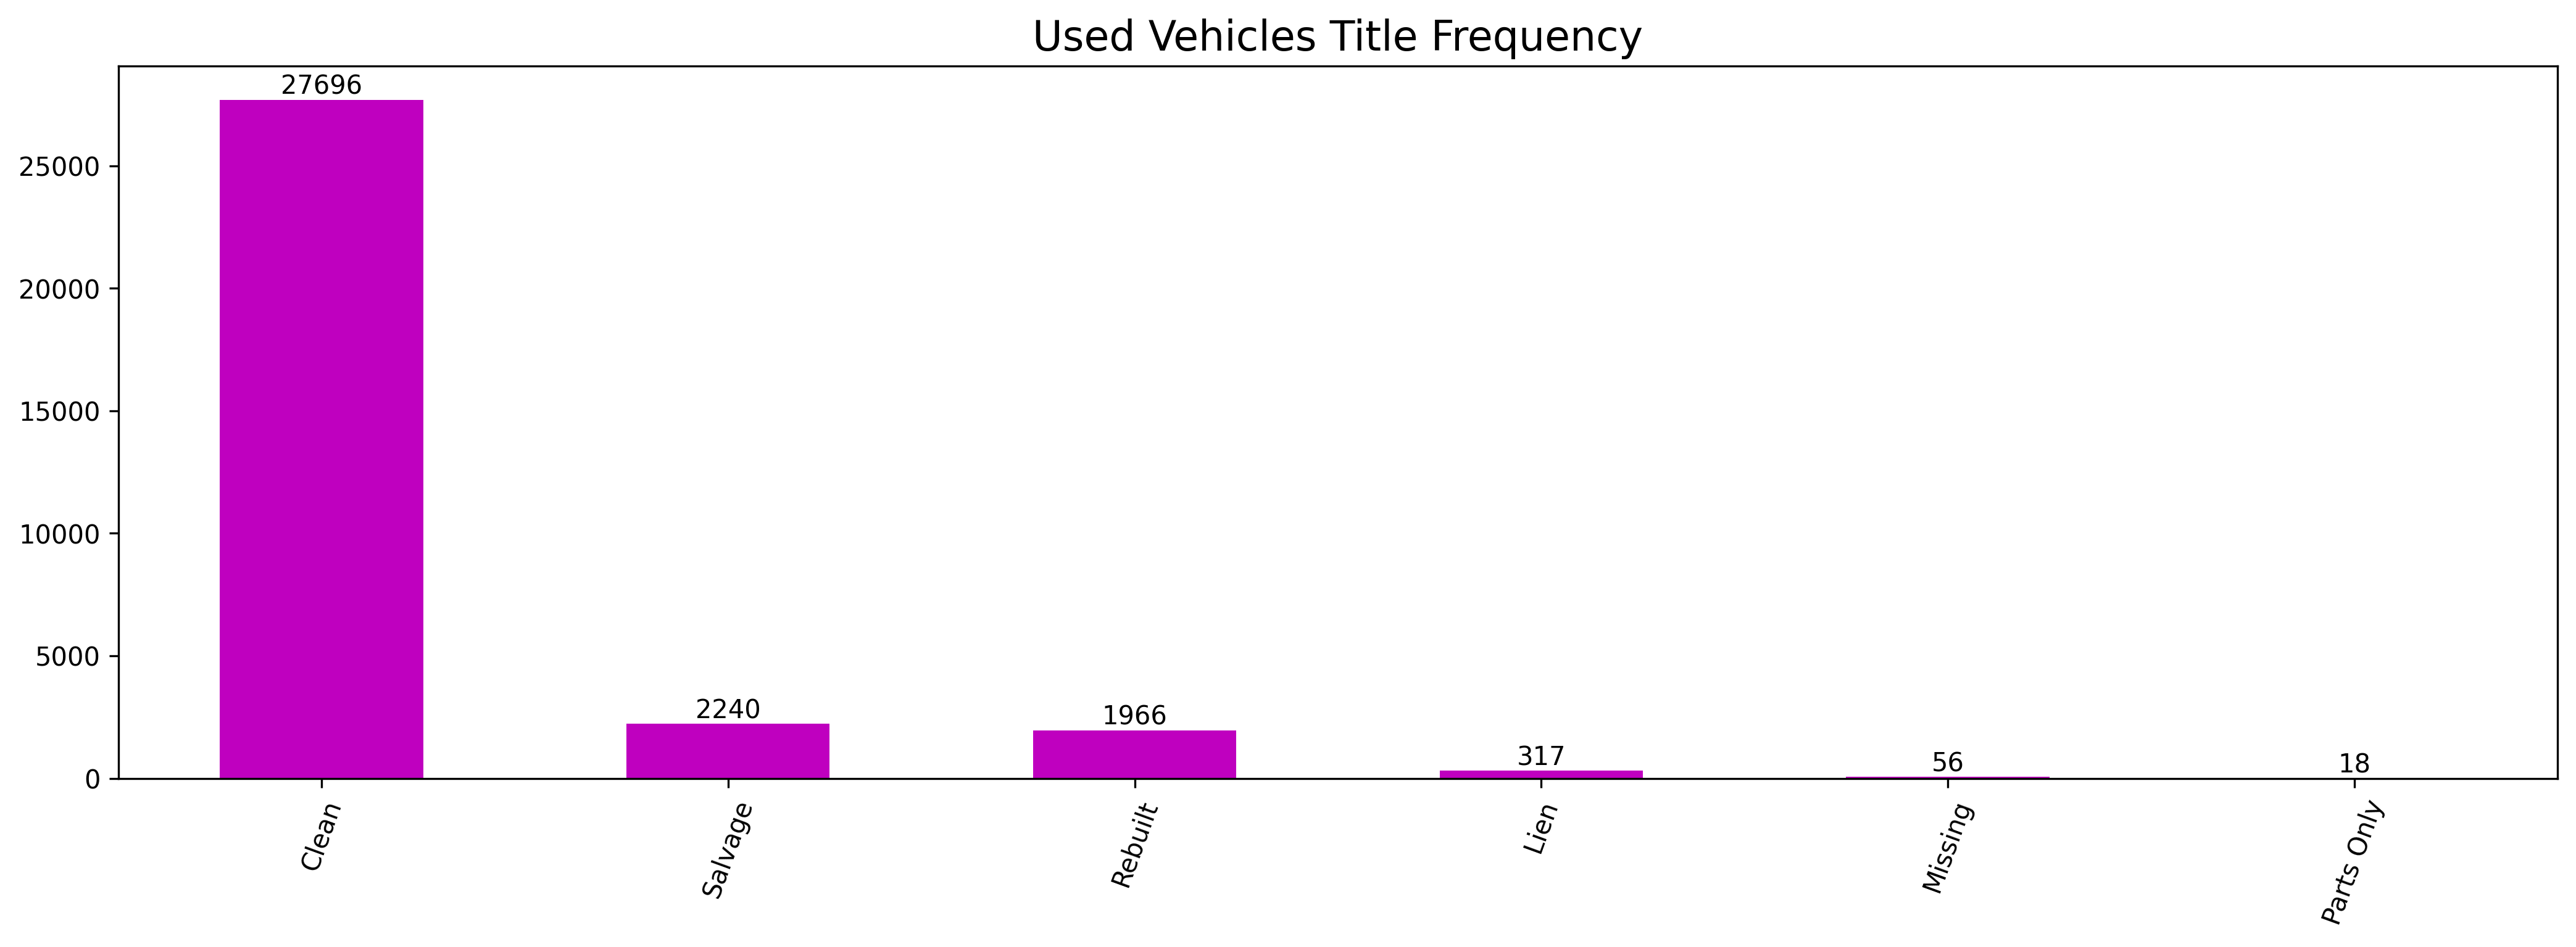

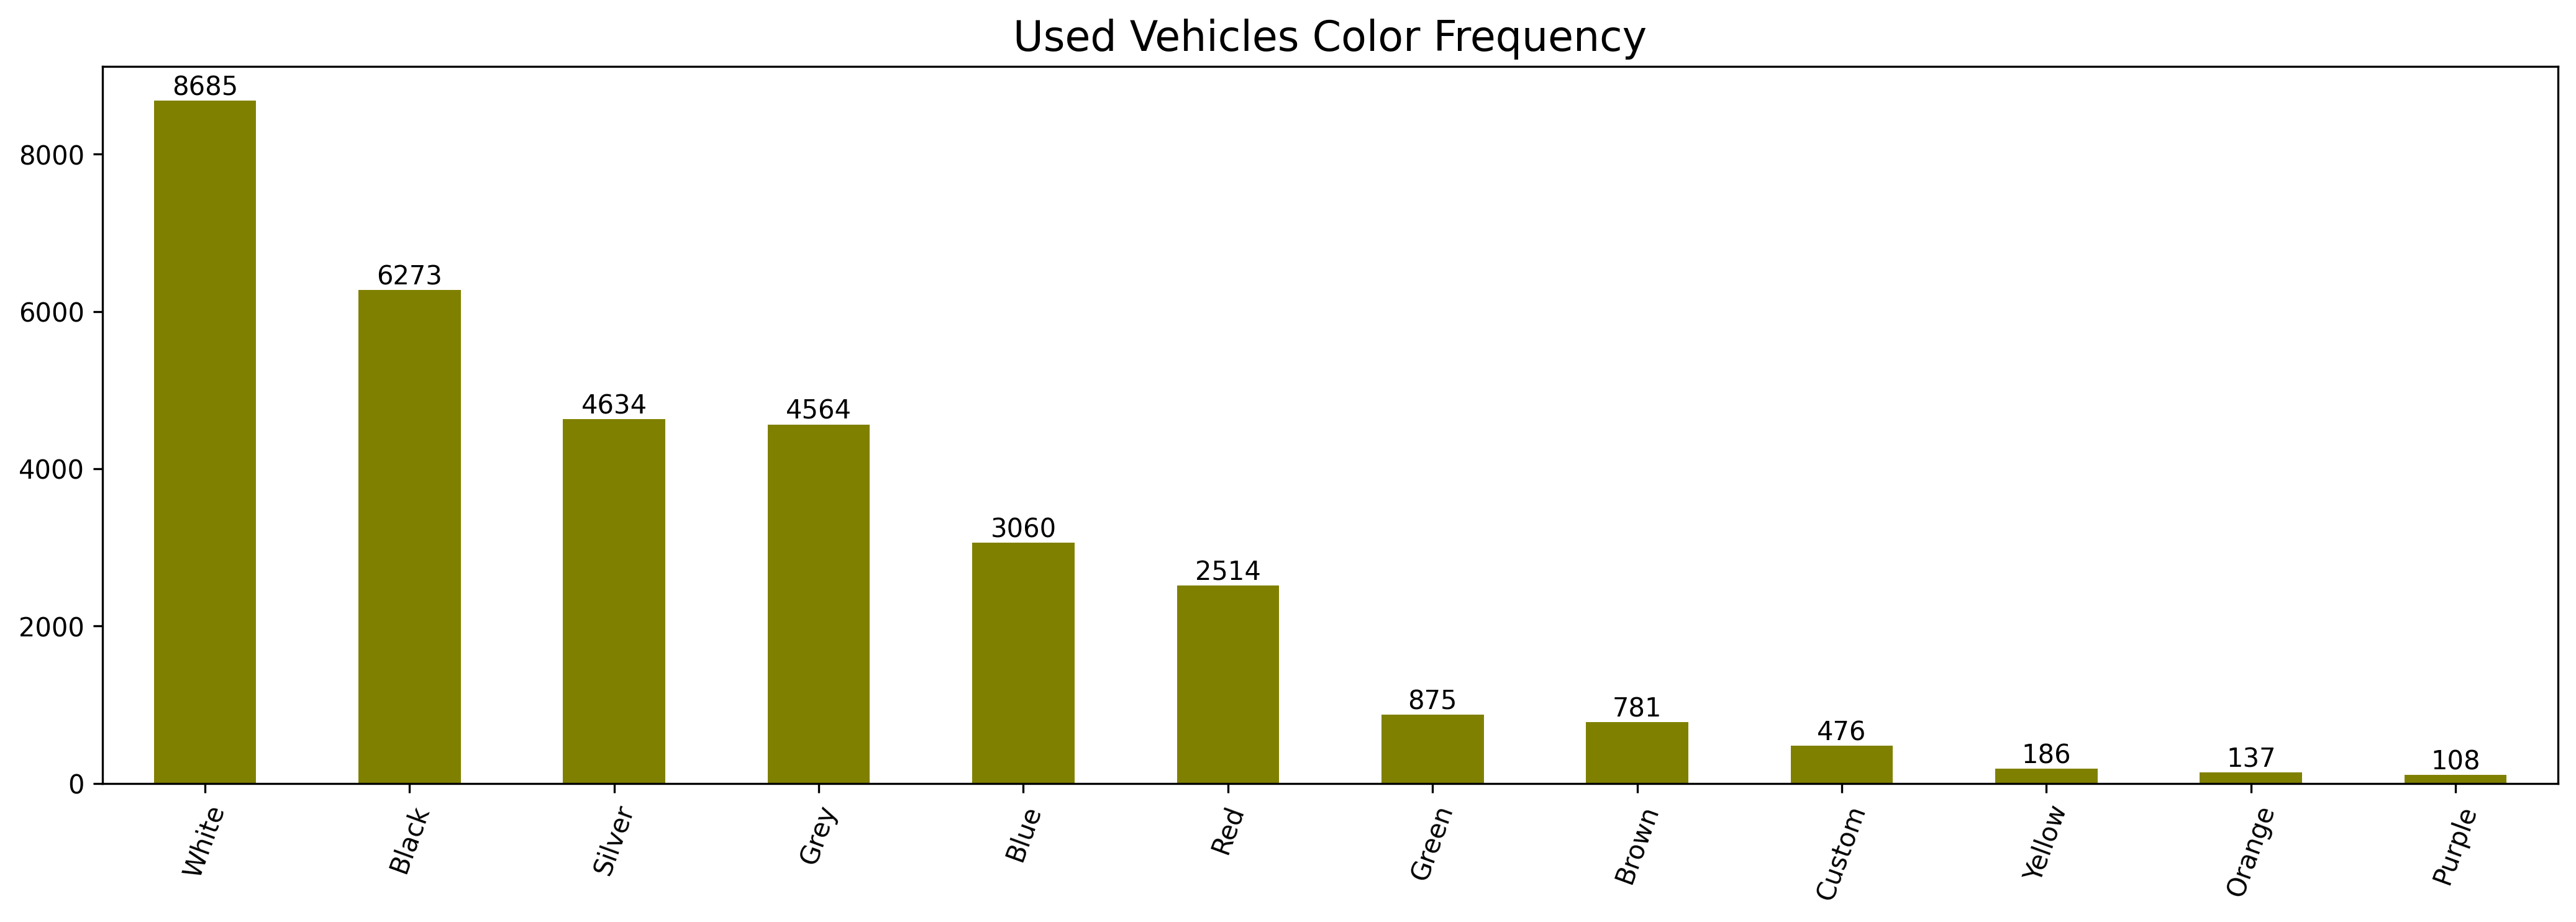

In [22]:
categories = ['Fuel','Cylinders','Drive','Title', 'Color']
colors = ['cornflowerblue', 'c', 'g','m','olive','chocolate']
for category, color in zip(categories, colors):
    plt.figure(figsize = [17,5],dpi = 300)
    ax = df[category].value_counts().plot(kind='bar', color = color);
    for bars in ax.containers:
        ax.bar_label(bars);
    plt.xticks(rotation=70);
    plt.title("Used Vehicles " + category + " Frequency", fontsize = 16);

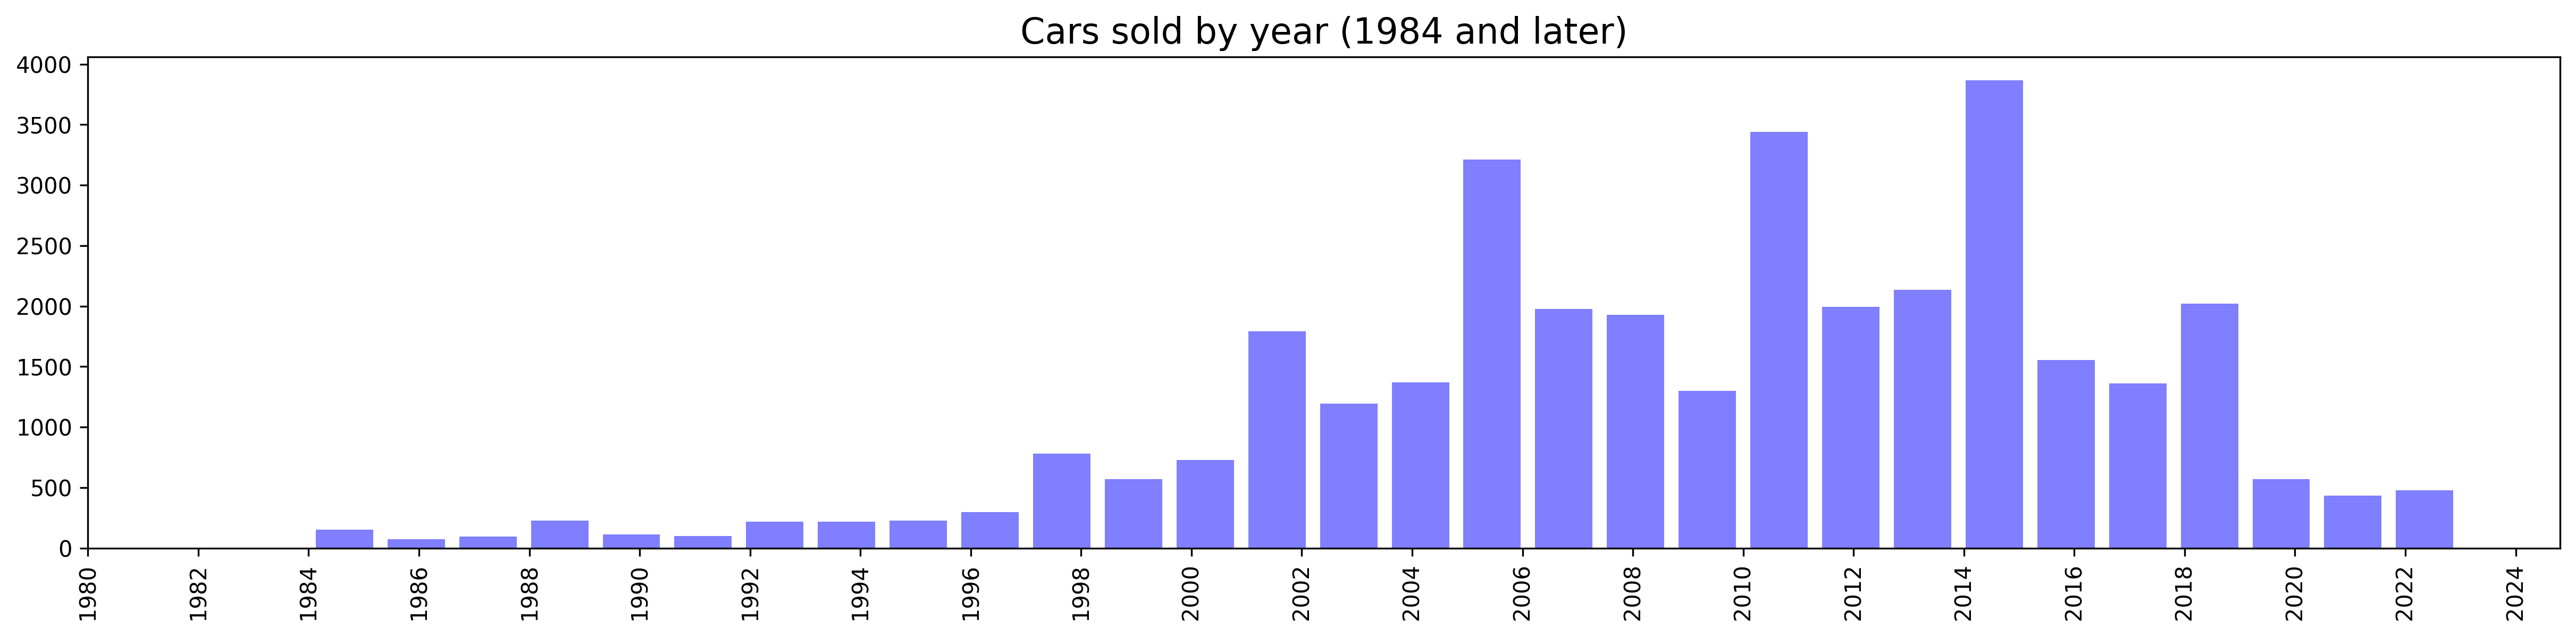

In [32]:
fig, ax = plt.subplots(1,1,figsize=(20,4), dpi = 300)
histogram = plt.hist(df['Year'].sort_values(),bins = 30, rwidth=0.8,facecolor='blue', alpha=0.5)
histogram = plt.xticks(ticks = np.arange(1980,2026,2),rotation = 90)
plt.title('Cars sold by year (1984 and later)', loc = 'center', fontsize = 16);

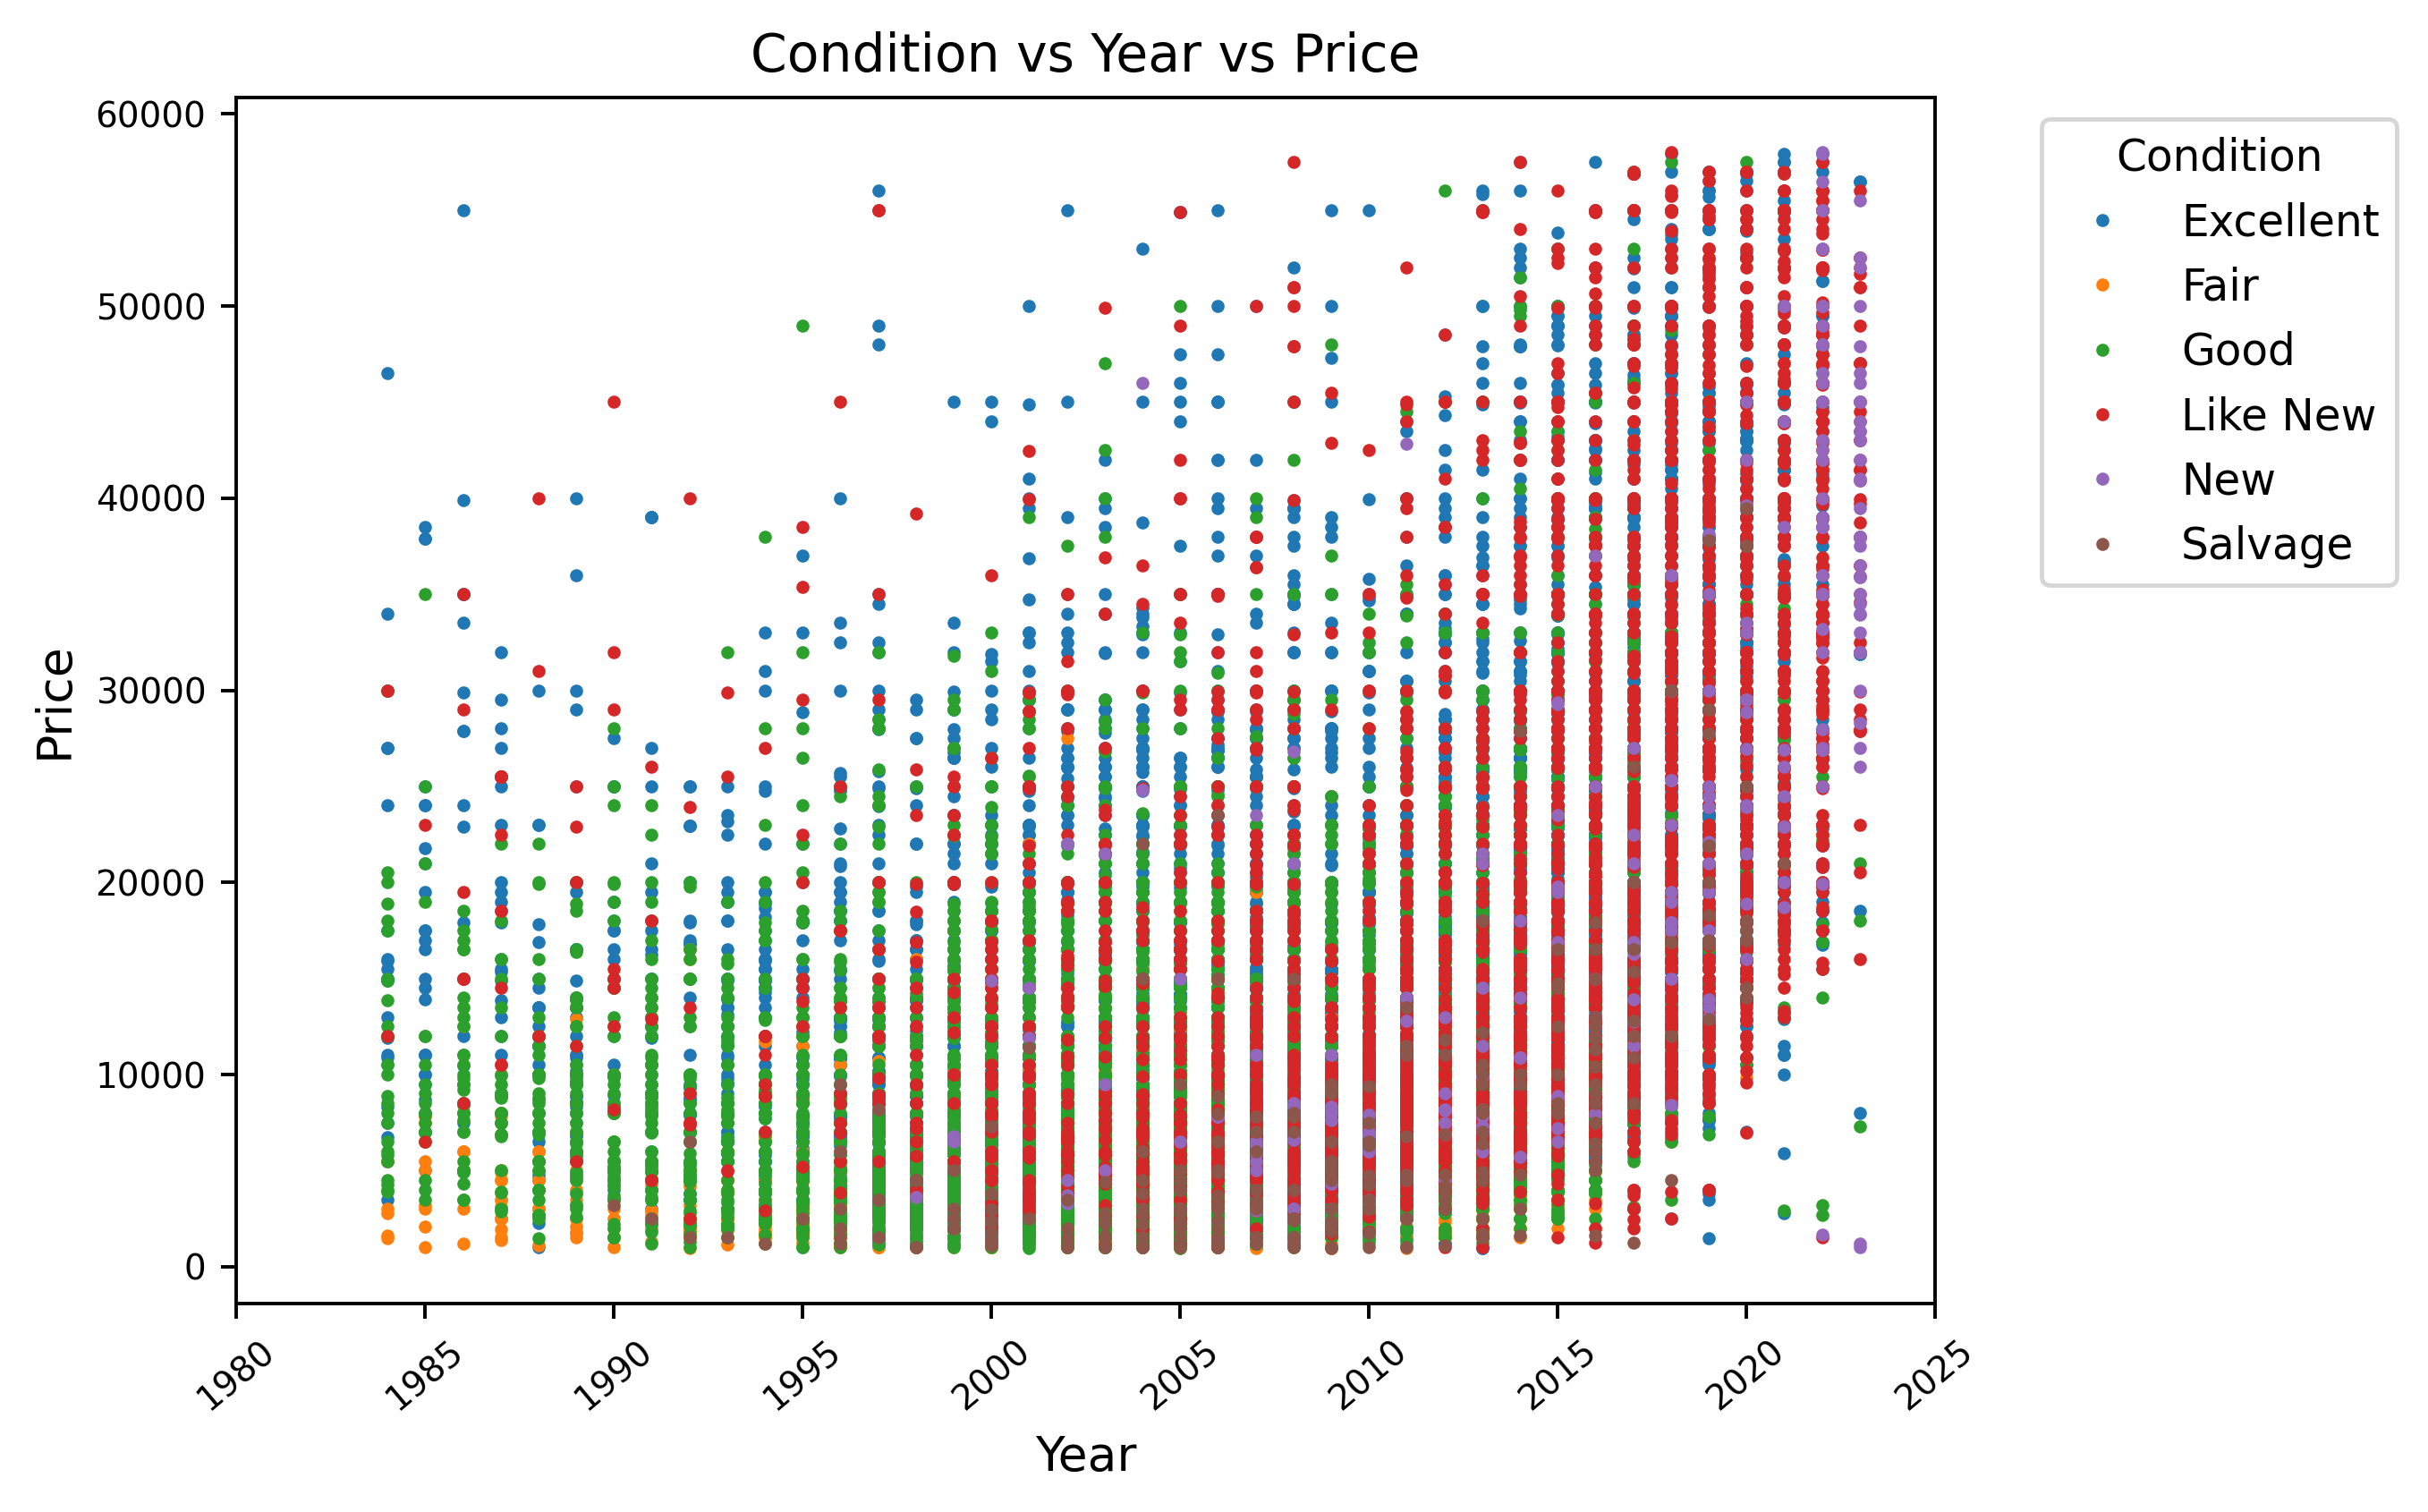

In [23]:
fig, ax = plt.subplots(1,1,figsize=(7,5), dpi = 350)
dft = df.groupby('Condition')

for name, group in dft:
    ax.plot(group.Year, group.Price, marker='o', linestyle='', ms=2, label=name)

# Place legend outside of the graph
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Condition')

# Set x and y labels
ax.set_xlabel('Year',fontsize = 11)
ax.set_ylabel('Price', fontsize = 11)

plt.title('Condition vs Year vs Price', loc = 'center', fontsize = 12);
plt.xticks(np.arange(1980,2030,5),rotation = 40,fontsize = 8)
plt.yticks(fontsize = 8)
plt.show()


### Heatmaps

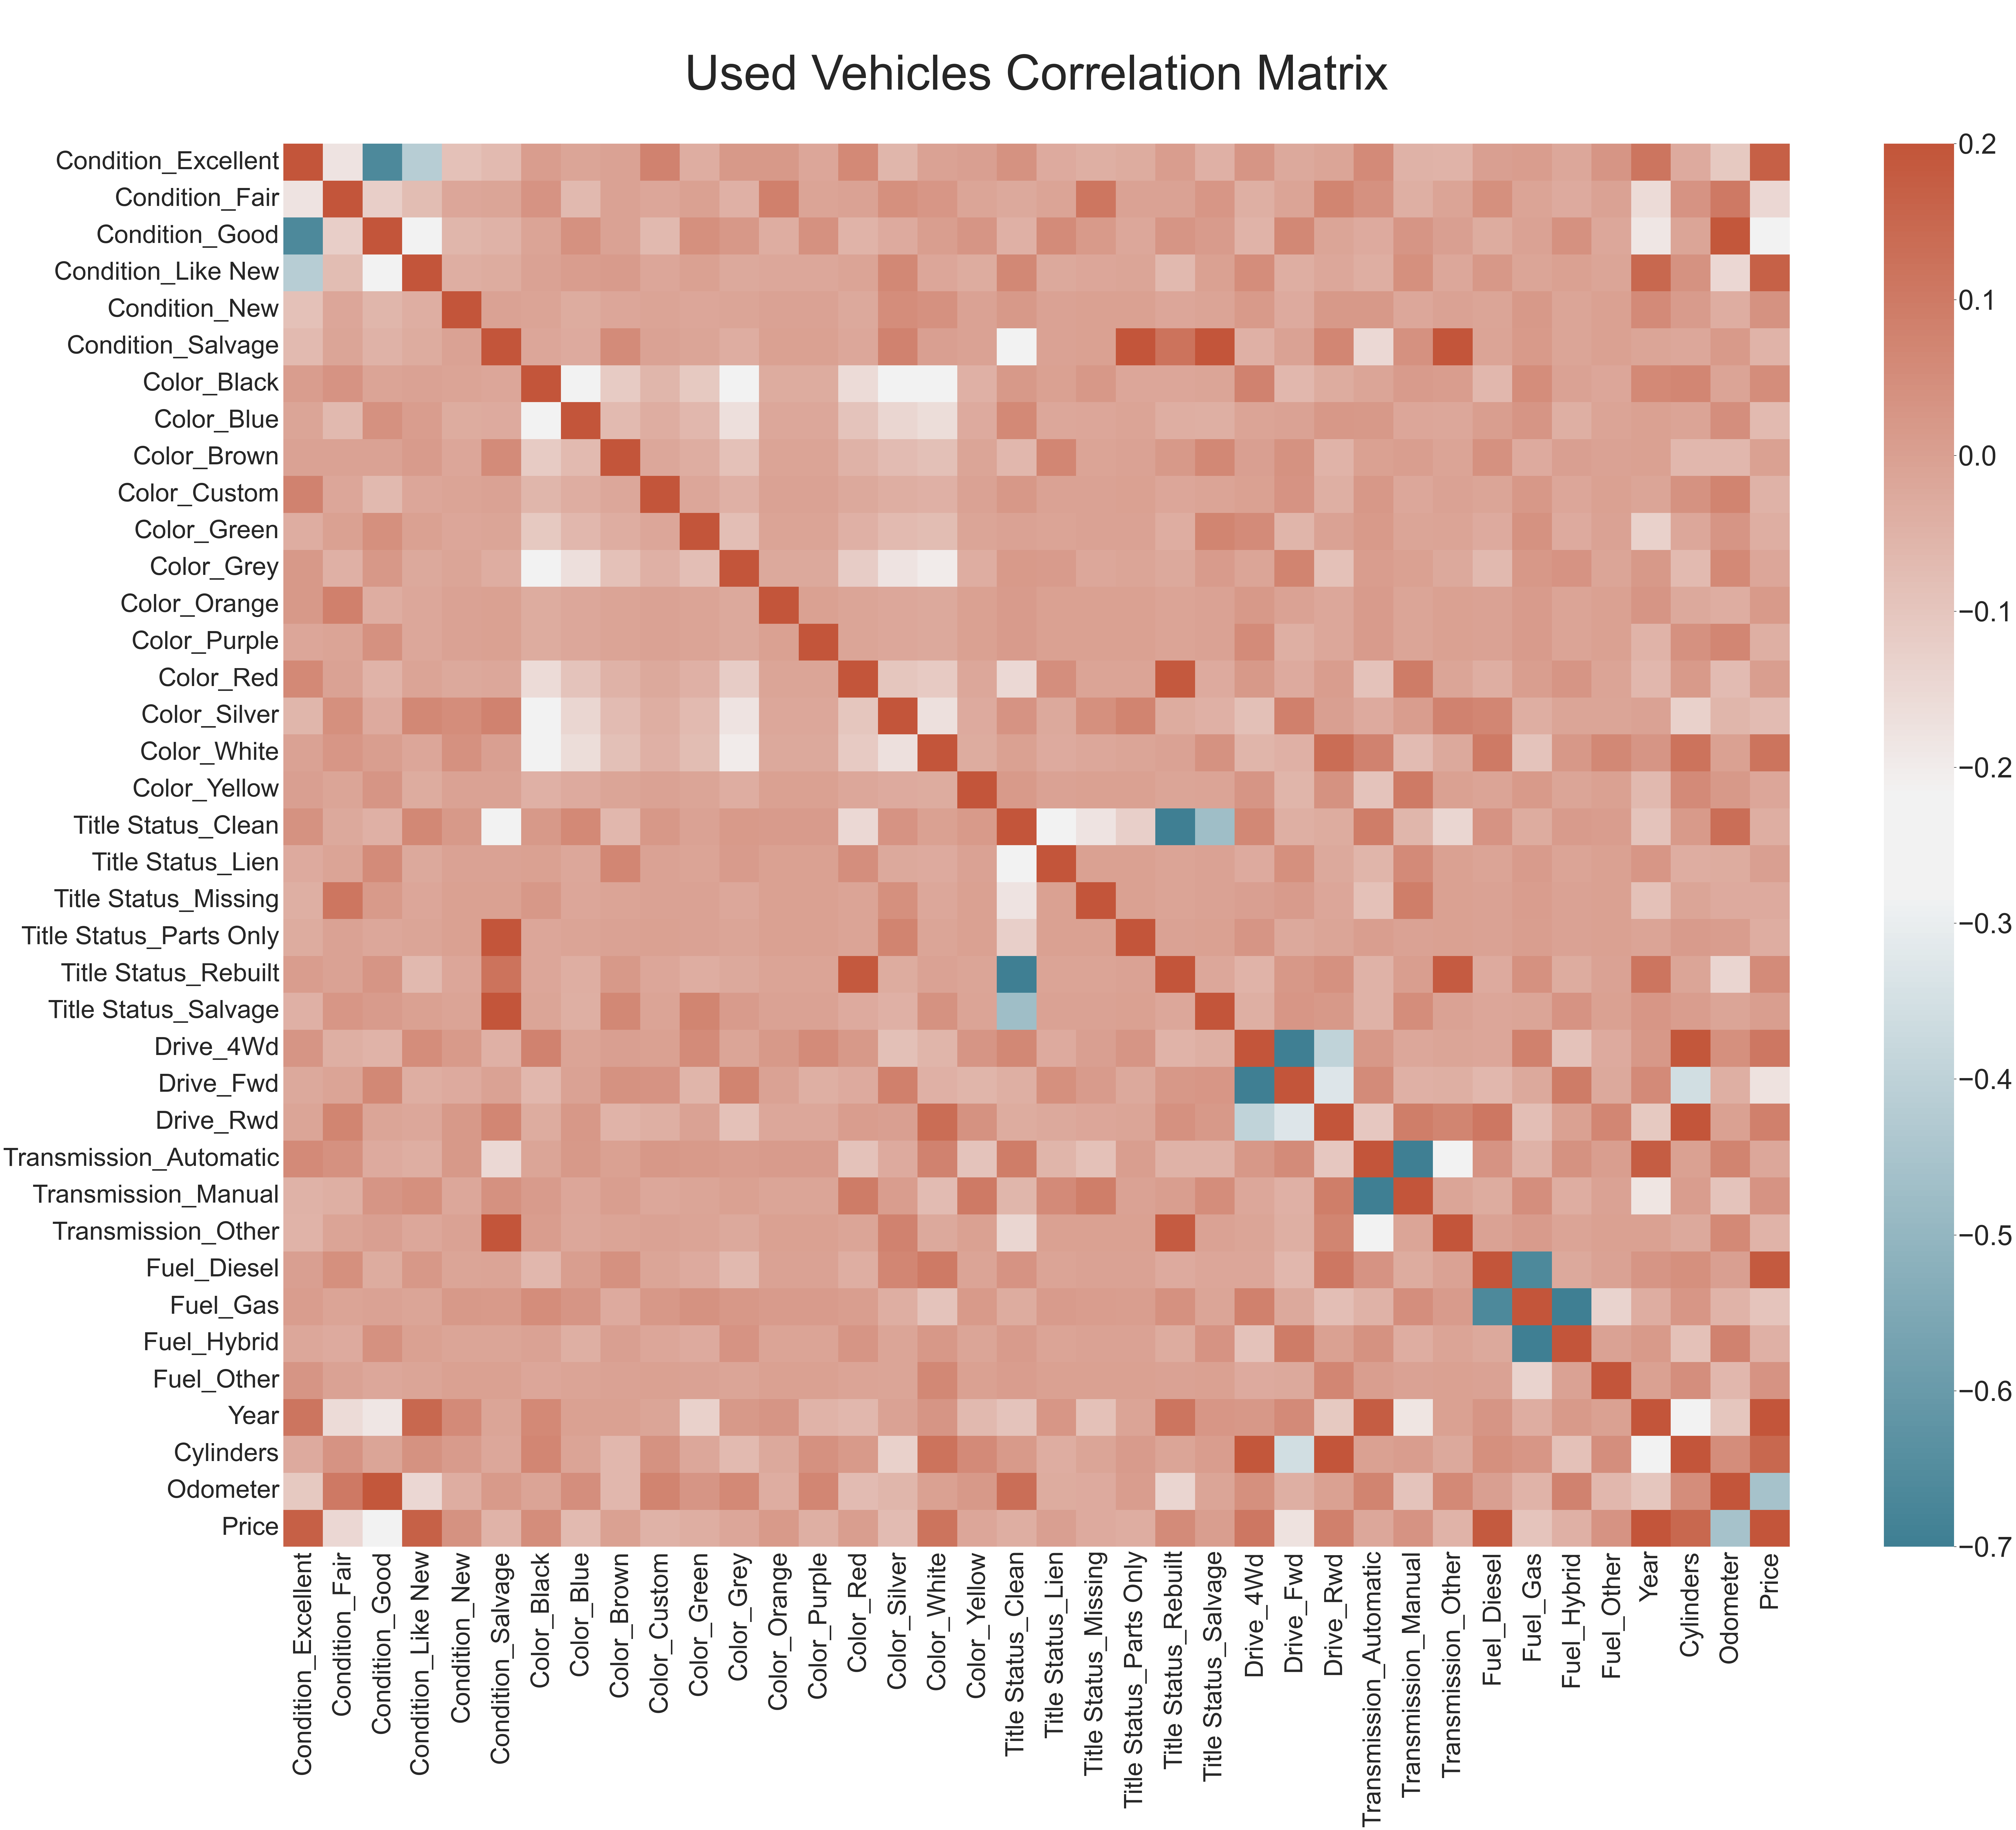

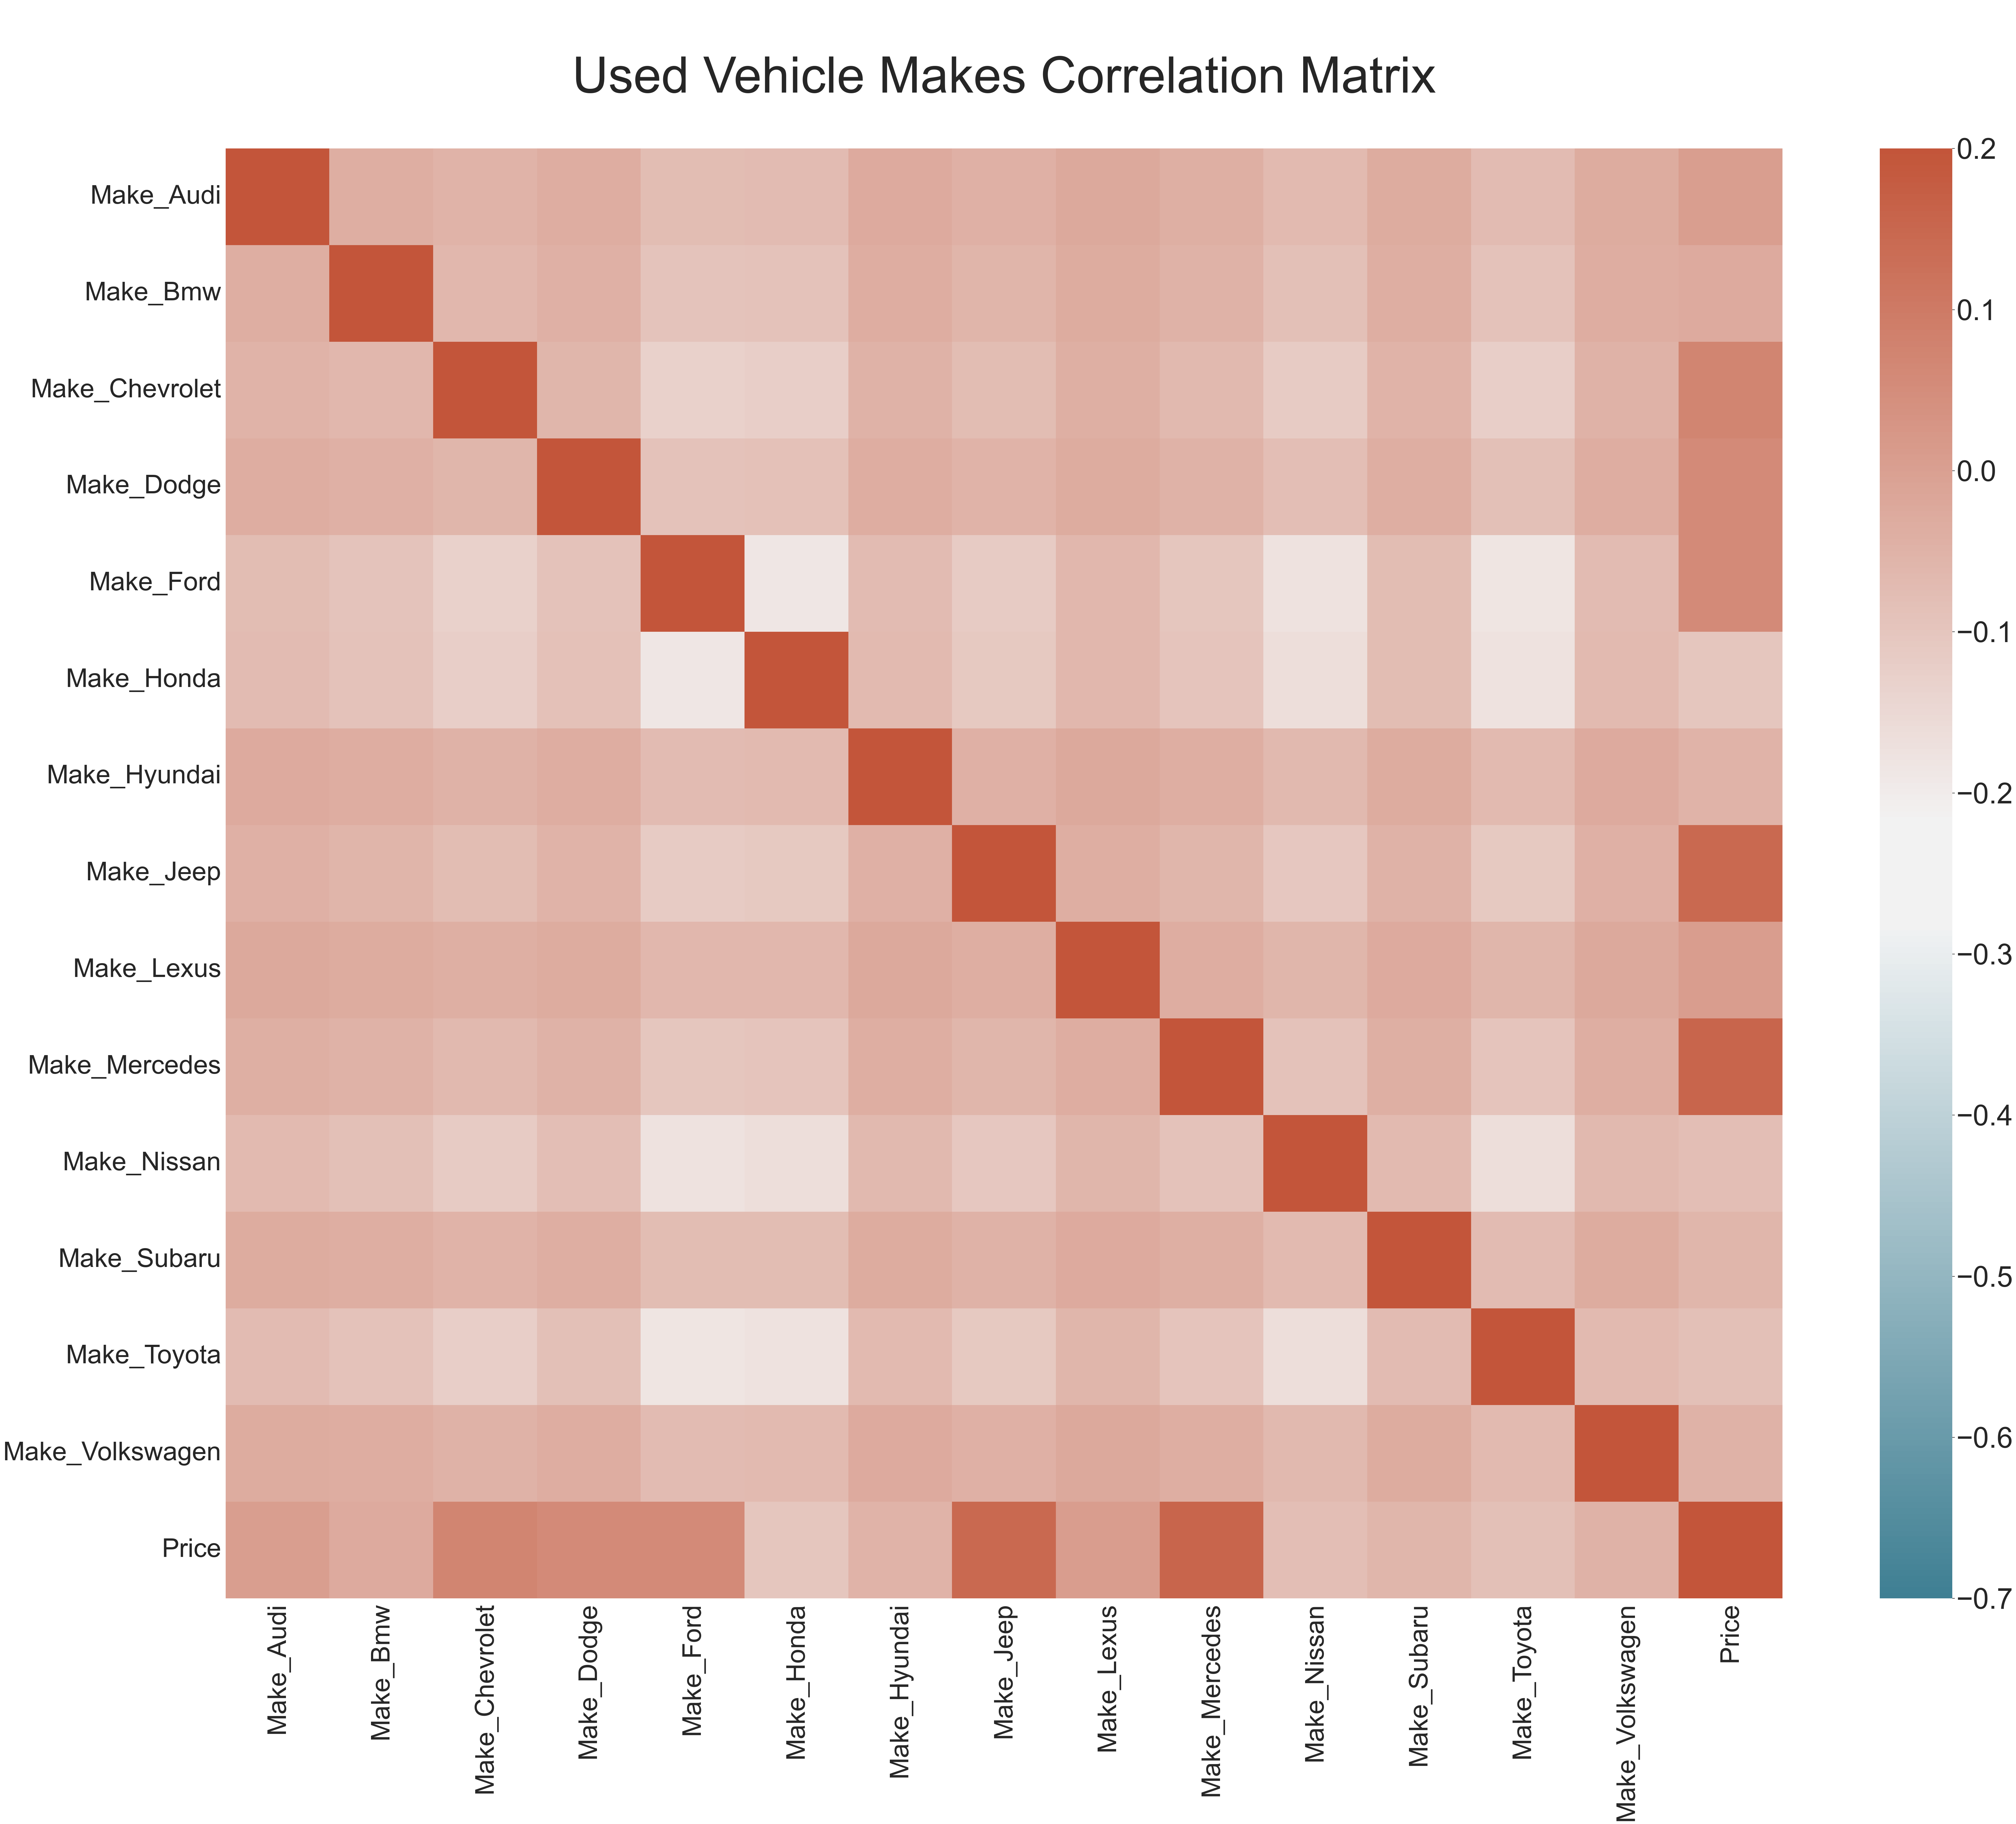

In [325]:
for dataframe, title in zip([df_other_final,df_make_final],['\nUsed Vehicles Correlation Matrix\n',\
                           '\nUsed Vehicle Makes Correlation Matrix\n']):
    plt.figure(figsize=(80, 60))
    sns.set(font_scale=6)
    cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
    corr = dataframe.corr()
    #matrix = np.triu(corr)
    fig = sns.heatmap(corr,vmin = -0.7,vmax = 0.2,annot = False,cmap=cmap)
    fig.set_title(title,fontsize = 115)
    plt.xticks(fontsize = 60)
    plt.yticks(fontsize = 60)
    plt.show()

# fig_makes = sns.heatmap(df_make_final.corr(),vmin = -0.7,vmax = 0.2,annot = False,cmap=cmap)
# fig_makes.set_title('\nUsed Vehicles Makes Correlation Matrix\n',fontsize = 115)

## Outliers

### Before Filtering:

#### Distrubition bar charts:

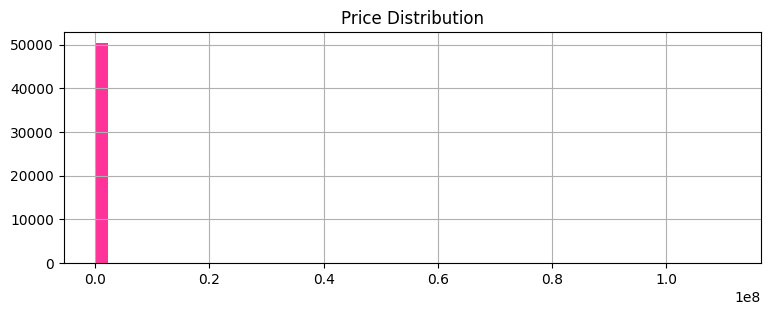

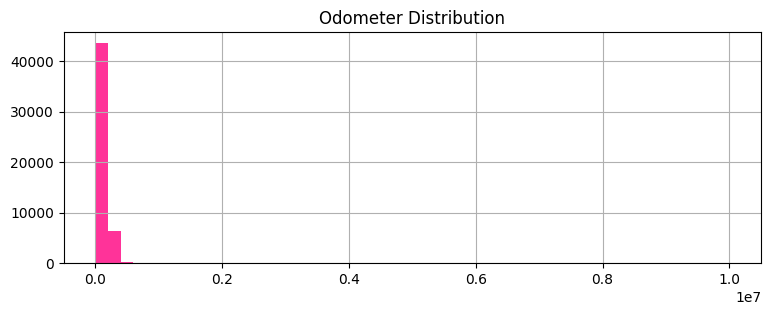

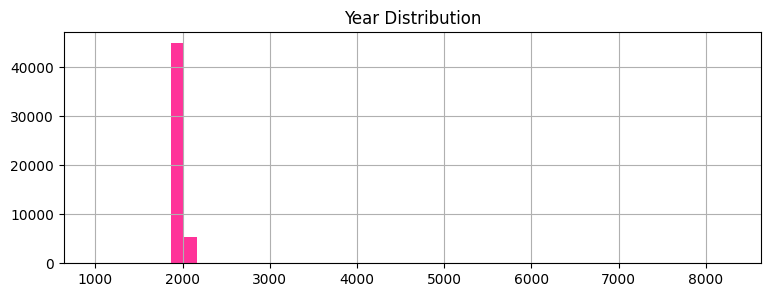

In [15]:
# a different view of the distributions
for i in ["Price", "Odometer","Year"]:
    df_raw[i].hist(bins=50,figsize=(9, 3),color='#FF3399');
    plt.title(i + ' Distribution', loc = 'center');
    plt.show()

#### Box Plots:

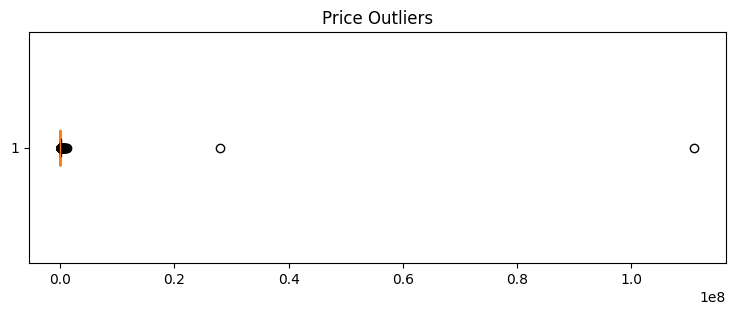

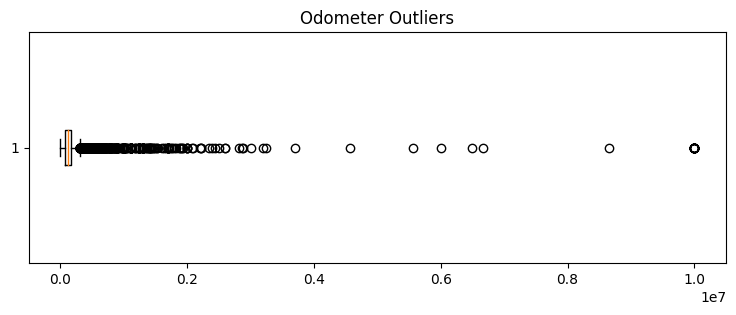

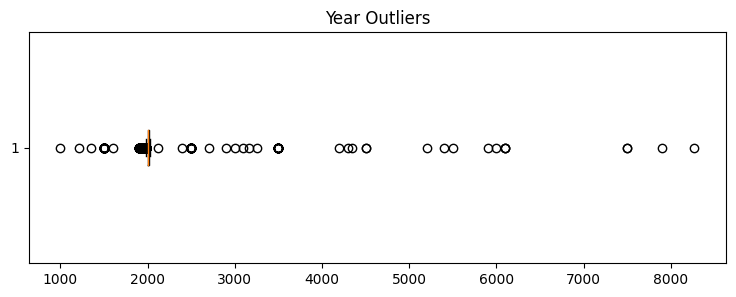

In [14]:
# check price distribution for outliers
for i in ["Price", "Odometer", "Year"]:
    fig, ax = plt.subplots(1,1,figsize=(9,3))
    boxplot = plt.boxplot(df_raw[i], showfliers=True, vert=False)
    plt.title(i+ " Outliers", loc = 'center')

As we can see, the data is all over the place. This will not do. For this reason (and after many trial and errors), we arrive at the following filter criteria: 
- **Price:** Mininum: 900 Maximum: 98th quantile
- **Odometer:** Maximum: 350000
- **Year:** Minimum: 1983 Maximum: 2024

### After Filtering:

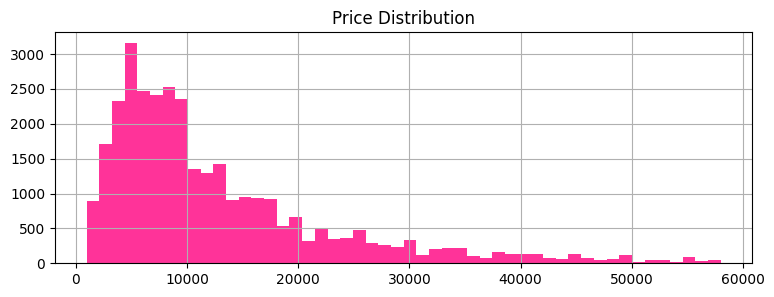

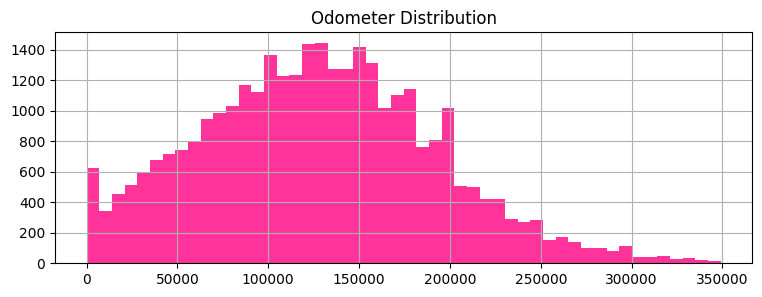

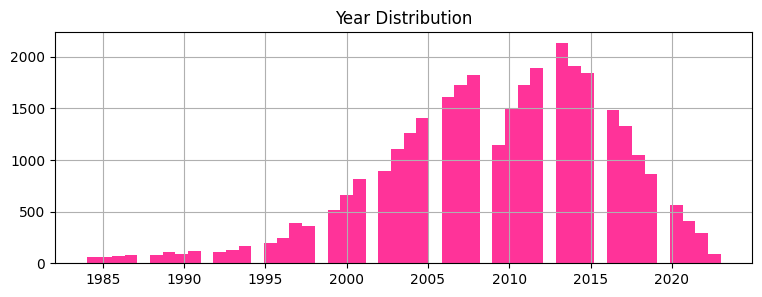

In [18]:
# a different view of the distributions
for i in ["Price", "Odometer","Year"]:
    df[i].hist(bins=50,figsize=(9, 3),color='#FF3399');
    plt.title(i + ' Distribution', loc = 'center');
    plt.show()

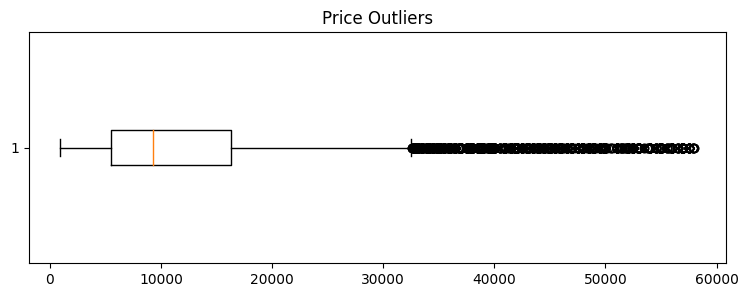

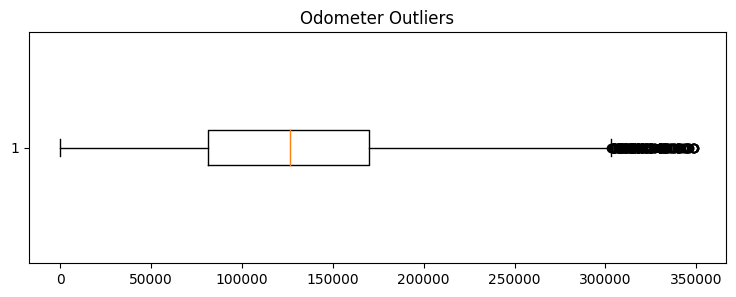

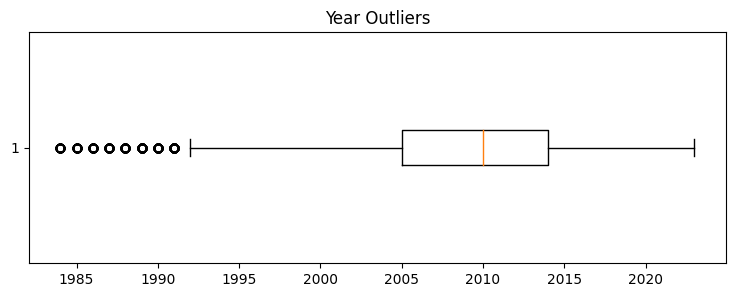

In [17]:
# check price distribution for outliers
for i in ["Price", "Odometer", "Year"]:
    fig, ax = plt.subplots(1,1,figsize=(9,3))
    boxplot = plt.boxplot(df[i], showfliers=True, vert=False)
    plt.title(i+ " Outliers", loc = 'center')

This looks much better!